# Implementação de um codigo de Eigenfaces

<script type="text/x-mathjax-config">
MathJax.Hub.Config({
tex2jax: {
inlineMath: [['$','$'], ['\\(','\\)']],
processEscapes: true},
jax: ["input/TeX","input/MathML","input/AsciiMath","output/CommonHTML"],
extensions: ["tex2jax.js","mml2jax.js","asciimath2jax.js","MathMenu.js","MathZoom.js","AssistiveMML.js", "[Contrib]/a11y/accessibility-menu.js"],
TeX: {
extensions: ["AMSmath.js","AMSsymbols.js","noErrors.js","noUndefined.js"],
equationNumbers: {
autoNumber: "AMS"
}
}
});
</script>
<p style="opacity: 0.5">< ⚙️ Magical code to run latex on markdown here ></p>

A idea por trás dos algoritmos de eigenfaces é interpretar imagens como vetores para então aplicar conceitos de algebra linear e conseguir resultados interessantes.
No algoritmo em questão, fazemos uma matriz onde cada coluna representa uma imagem. A partir dela geramos uma matriz de covariancia, multiplicando a matriz das imagens pela sua transversa.
Dessa nova matriz, extraímos os autovalores e autovetores, e ordenamos eles conforme os autovalores mais altos, que representam o peso que aquele vetor componente possui nas descrições das imagens.

In [116]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import Markdown as md #deixar o markdown mais interessante

Para a leitura de imagens eu roubei esse codigo que é muito interessante

In [117]:
IMAGE_DIR = 'training-images'
DEFAULT_SIZE = [250, 250] 

def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')]
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir)
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')]
        for image_name in image_names:
            image = Image.open (os.path.join(dir_path, image_name))
            image = image.convert ("L")
            # resize to given size (if given )
            if (default_size is not None ):
                image = image.resize (default_size , Image.ANTIALIAS )
            images.append(np.asarray (image , dtype =np. uint8 ))
            images_names.append(image_dir)
    return [images,images_names]



In [118]:
[X, y] = read_images()
print("Exemplo de como uma imagem está armazenada (X[0]): ")
print(X[0])
print(type(X[0]))
print("Numero de arrays dentro desse primeiro array (tamanho de X[0]):")
print(len(X[0]))
print("Numero de arrays dentro cada um desses arrays interiores (tamanho de X[0][0]):")
print(len(X[0][0]))
print("Ou seja, cada imagem está armazenada como uma lista com 250 'linhas', onde cada linha tem 250 entradas, cada uma correspondente a um pixel da imagem.")

Exemplo de como uma imagem está armazenada (X[0]): 
[[  0   0   0 ...   1   1   1]
 [  0   0   0 ...   0   0   0]
 [  0   0   1 ...   3   3   3]
 ...
 [119 125 133 ... 130 143 150]
 [118 120 127 ... 137 150 157]
 [114 116 123 ... 143 154 161]]
<class 'numpy.ndarray'>
Numero de arrays dentro desse primeiro array (tamanho de X[0]):
250
Numero de arrays dentro cada um desses arrays interiores (tamanho de X[0][0]):
250
Ou seja, cada imagem está armazenada como uma lista com 250 'linhas', onde cada linha tem 250 entradas, cada uma correspondente a um pixel da imagem.


In [119]:
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10) ):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )


total face-count:  53


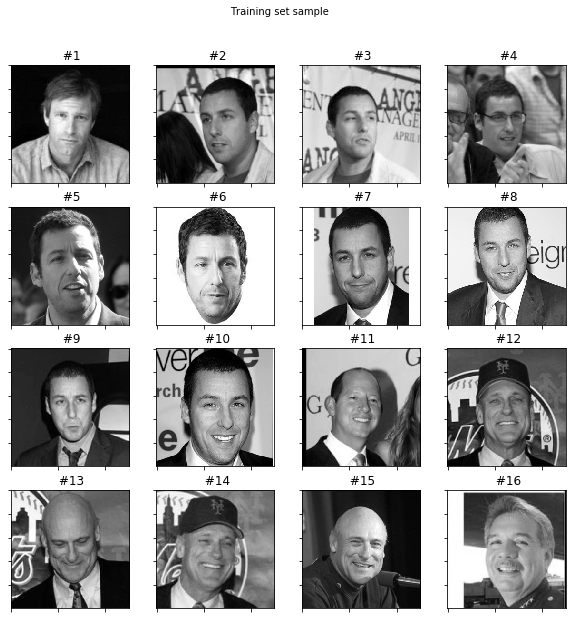

In [120]:
E = []
number = len(X)
for i in range (min(number, 16)):
    E.append(np.asarray(X[i]))
subplot ( title ="Training set sample", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="sample-of-initial-faces.png")
print("total face-count: ",number)

Agora para prosseguir com os calculos precisamos que cada imagem seja um vetor de valores reais, e não uma lista de listas, para isso, as informações dos valores de cada pixel serão ordenados e transformados em um vetor com 250x250=62500 entradas.

In [121]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c 
    return mat

In [122]:
images_as_rows = as_row_matrix(X)
print("Shape da matriz (colunas = imagens, linhas = pixels da imagem)")
images_as_rows.shape

Shape da matriz (colunas = imagens, linhas = pixels da imagem)


(53, 62500)

Temos então $ X= \begin{bmatrix}F_1 & F_2 & ... & F_n \end{bmatrix} $
Com $F_{1xn}$ com $n$ sendo o nosso numero de pixels por imagem

Agora que cada imagem é um vetor, é possivel realizar operações entre vetores e exibir um vetor como uma imagem, um exemplo disso é o vetor médio $m$, ou a face média, obtida pela media dos vetores:

$m = \frac{1}{n}\sum_{i=1}^{n} F_i $

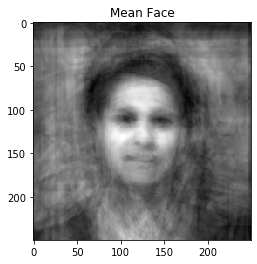

In [123]:
average_weight = np.reshape(images_as_rows.mean(axis =0), DEFAULT_SIZE)
plt.imshow(average_weight, cmap=plt.cm.gray)
plt.title("Mean Face")
plt.show()

Para prosseguir com o procedimento de busca pelas eigenfaces, o proximo passo é subtrair esse vetor "mean face" das imagens de faces, para termos então o que cada face específica acrescenta de caracteristica nova à face media.
Teremos então  $\phi_i = F_i - m$ 

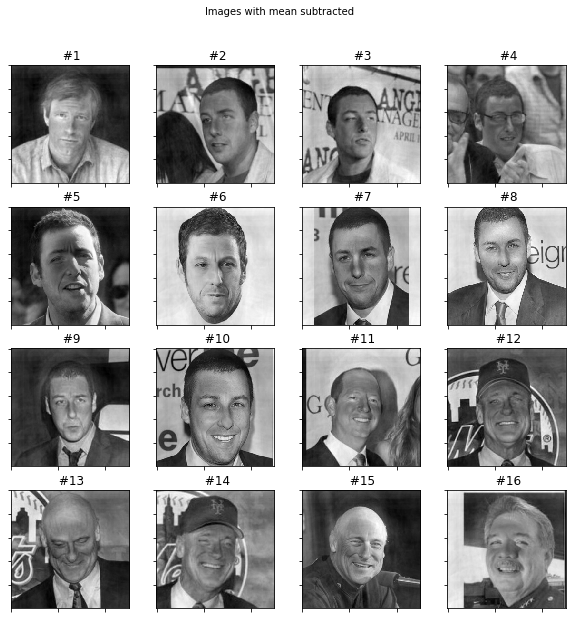

In [125]:
E = []
img_x = X
number = len(img_x)
for i in range (min(number, 16)):
    E.append(np.asarray(img_x[i]-average_weight))
subplot ( title ="Images with mean subtracted", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="images-subtracted-mean.png")

In [126]:
X = images_as_rows
m = X.mean(axis =0)
phi = X - m
[n,m] = phi.shape

A partir dessa matriz vamos montar uma matriz de covariancia $C$, em que reza lenda $C=\phi \phi^T$, e encontrar os autovalores e autovetores dela. Com isso, teremos, pela logica do funcionamento dos autovetores, todo um rolê de PCA aqui que eu não sei nada, e com isso nos sabemos que podemos retirar os autovetores com valores mais altos pois eles possuem maior influencia nas caracteristicas das imagens, e portanto eles são nossas eigenfaces

In [127]:
if n>m: # Condição para executar o codigo mais rapido. (devido ao custo de calcular phi * phi^T, isso é contornado dessa forma, tirando proveito de que os autovalores da transposta são os mesmos:)
    C = np.dot(phi.T,phi) # Covariance Matrix
    [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    eigenvectors = eigenvectors.T
else :
    C = np.dot (phi,phi.T) # Covariance Matrix
    [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    eigenvectors = np.dot(phi.T, eigenvectors )
    for i in range (n):
        eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    eigenvectors = eigenvectors.T

In [128]:
eigenvalues

array([-1.93848618e-07,  2.74729356e+07,  3.50763318e+07,  3.86957144e+07,
        4.41083487e+07,  4.72196324e+07,  5.13979471e+07,  5.46550184e+07,
        5.70512133e+07,  6.17332113e+07,  6.21466948e+07,  6.77918273e+07,
        7.11753549e+07,  7.30380594e+07,  7.62823587e+07,  7.90552122e+07,
        8.30627476e+07,  8.67445336e+07,  9.05442335e+07,  9.64017584e+07,
        1.00210699e+08,  1.01953351e+08,  1.09484678e+08,  1.10803401e+08,
        1.16763916e+08,  1.24513545e+08,  1.34634062e+08,  1.36356075e+08,
        1.38476814e+08,  1.47684922e+08,  1.53225013e+08,  1.57191040e+08,
        1.76733640e+08,  1.81753568e+08,  1.99013053e+08,  2.10355220e+08,
        2.37773627e+08,  2.47232113e+08,  2.62924145e+08,  3.00765393e+08,
        3.01989474e+08,  3.08950309e+08,  3.31042454e+08,  4.86496024e+08,
        5.11574938e+08,  5.33538980e+08,  6.16015576e+08,  6.87684783e+08,
        9.45368080e+08,  1.03778983e+09,  1.38688891e+09,  2.00595950e+09,
        5.05912241e+09])

In [129]:
eigenvectors

array([[-8.07221223e-04, -1.62517964e-03,  2.19684535e-05, ...,
         4.10475143e-03,  1.38460730e-03, -3.27916610e-03],
       [-1.18092864e-03, -1.27982792e-03, -1.46948353e-03, ...,
        -1.22528807e-03, -2.31943177e-03, -1.93159856e-03],
       [-4.02196045e-03, -4.33491810e-03, -4.46812717e-03, ...,
         5.80093639e-03,  6.04052529e-03,  4.01548922e-03],
       ...,
       [-4.62573256e-03, -4.72923624e-03, -4.82178711e-03, ...,
         7.70555484e-03,  7.28286793e-03,  6.46134523e-03],
       [-4.55393569e-03, -4.60845384e-03, -4.66211160e-03, ...,
        -4.62807797e-03, -4.23643053e-03, -4.21416230e-03],
       [-6.32625586e-03, -6.23961090e-03, -6.18154926e-03, ...,
        -2.59049122e-03, -2.71515793e-03, -3.16632253e-03]])

Ordenamos agora os autovalores e autovetores conforme oq já disse ali em cima

In [130]:
ordered_index = np.argsort (- eigenvalues )
eigenvalues = eigenvalues [ordered_index] # O autovalor i se torna o elemento de indice i conforme lista de indices ordenados
eigenvectors = eigenvectors [ordered_index] # O autovetor i se torna o vetor de indice i conforme lista de indices ordenados

In [131]:
eigenvectors

array([[-6.32625586e-03, -6.23961090e-03, -6.18154926e-03, ...,
        -2.59049122e-03, -2.71515793e-03, -3.16632253e-03],
       [-4.55393569e-03, -4.60845384e-03, -4.66211160e-03, ...,
        -4.62807797e-03, -4.23643053e-03, -4.21416230e-03],
       [-4.62573256e-03, -4.72923624e-03, -4.82178711e-03, ...,
         7.70555484e-03,  7.28286793e-03,  6.46134523e-03],
       ...,
       [-4.02196045e-03, -4.33491810e-03, -4.46812717e-03, ...,
         5.80093639e-03,  6.04052529e-03,  4.01548922e-03],
       [-1.18092864e-03, -1.27982792e-03, -1.46948353e-03, ...,
        -1.22528807e-03, -2.31943177e-03, -1.93159856e-03],
       [-8.07221223e-04, -1.62517964e-03,  2.19684535e-05, ...,
         4.10475143e-03,  1.38460730e-03, -3.27916610e-03]])

In [132]:
output = r" $ \Lambda = \begin{bmatrix}"+str(eigenvalues[0])+r" & 0 & ... & 0 \\ 0 & "+str(eigenvalues[1])+r" & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &"+str(eigenvalues[-1])+r" \end{bmatrix}$"
md(output)


 $ \Lambda = \begin{bmatrix}5059122407.823185 & 0 & ... & 0 \\ 0 & 2005959495.6029186 & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &-1.9384861828572986e-07 \end{bmatrix}$

Agora que temos $\Lambda$ onde as colunas seguem com cada $\lambda$ em ordem crescente, podemos selecionar apenas um numero de autovalores, e respectivos autovetores, de modo a jogar fora os auto

Aqui da pra ver a influencia deles, se eu entendi certo o algoritmo

In [133]:
def get_eigen_value_distribution(eigenvectors):
    return np.cumsum(eigenvectors) / np.sum(eigenvectors)

def plot_eigen_value_distribution(eigenvectors, interval):
    plt.scatter(interval, get_eigen_value_distribution(eigenvectors)[interval])

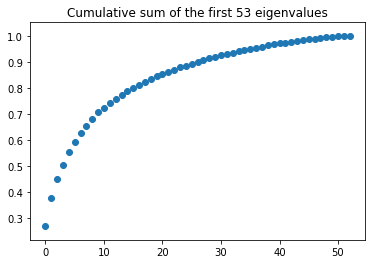

In [134]:
plot_eigen_value_distribution(eigenvalues, range(0, eigenvalues.shape[0]))
plt.title("Cumulative sum of the first {0} eigenvalues".format(eigenvalues.shape[0]))
plt.show()

Esse grafico ta horrivel de entender, mas nos ultimos alí, tem pouca diferença de um pro outro, então eles não acrescentam nada e <b style="font-weight:900;color: darkred">DEVEM SER ELIMINADOS</b>

Pra ver quantos autovetores, meio q pode ser um numero arbitrário, mas eu roubei esse codigo aqui:

In [135]:
def get_number_of_components_to_preserve_variance(eigenvalues, variance=.95):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii

In [136]:
num_components = get_number_of_components_to_preserve_variance(eigenvalues)
print("estamos selecionando ",num_components," de ",eigenvalues.shape[0]," autovetores")

estamos selecionando  35  de  53  autovetores


E agora temos nossa versão reduzida:

In [137]:
eigenvalues = eigenvalues [0: num_components ].copy ()
eigenvectors = eigenvectors [0: num_components ].copy ()

In [138]:
output = r" $ \Lambda = \begin{bmatrix}"+str(eigenvalues[0])+r" & 0 & ... & 0 \\ 0 & "+str(eigenvalues[1])+r" & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &"+str(eigenvalues[-1])+r" \end{bmatrix}$"
md(output)

 $ \Lambda = \begin{bmatrix}5059122407.823185 & 0 & ... & 0 \\ 0 & 2005959495.6029186 & ... & 0 \\ ... & ... & ... & ... \\ 0 & 0 & ... &90544233.53341874 \end{bmatrix}$

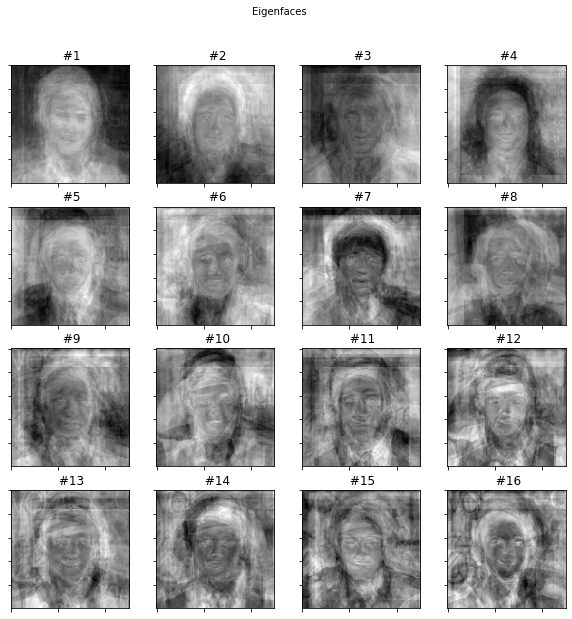

In [139]:
E = []
number = eigenvectors.shape[0]
for i in range (min(number, 16)):
    e = eigenvectors[i].reshape(DEFAULT_SIZE)
    E.append(np.asarray(e))
# plot them and store the plot to " python_eigenfaces .pdf"
subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="python_pca_eigenfaces.png")

GG piazada.

Aqui da pra ver a importancia dos autovetores:

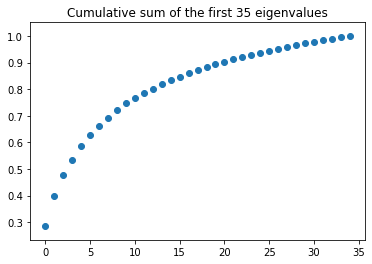

In [140]:
plot_eigen_value_distribution(eigenvalues, range(0, number))
plt.title("Cumulative sum of the first {0} eigenvalues".format(number))
plt.show()